In [1]:
# this involves standardization and normalization and is important as some models are sensitive to the feature scales

'''
for the small datasets the numbers with very high fluctuations can distort the model so better to do scaling
standard is used when the datas are normally distibuted and bell shaped
minmax is rare and for some specific requirements only
'''
import pandas as pd
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score,KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression # this beacause our dataset is smaller and it helps prevent overfitting
from sklearn.compose import ColumnTransformer # using this to broaden my knowledge


In [2]:
df= pd.read_csv("cleaned_data.csv")

# separate target and features as scaling is done in features
x=df[['TV','Radio','Newspaper']] # for selecting more columns we have to use double squared
y=df['Sales']

# for feature scaling we have to split the datasets into train and test to prevent the data leakage and donot do cheating
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.3, random_state=42)


In [4]:
# standard scaler using columntransformer

# this is a object and blueprint of what actually has to be done (no caluculations)
scaler = ColumnTransformer(
    transformers=[ 
        # tuple used as we might apply different methods i.e. scaling or encoding according to the columns
        ('scaled', StandardScaler(),['TV','Radio','Newspaper'])

    ],
    remainder='passthrough' # this keeps the unused columns as it is without removing
)

# now scaling train and test data which will be numpy array

# fit transform done so scaler lerans about the statisitcs of training data and tranforms / scales them
x_train_Scaled= scaler.fit_transform(x_train) 

# only transforming test data as fiting will leak the datas because we are predicting the test data and doing fiting will help model to see data previously.
x_test_Scaled= scaler.transform(x_test) 

# converting these arrays to the dataframe i.e. creates new dataframe
x_train_Scaled = pd.DataFrame(x_train_Scaled,columns=['TV','Radio','Newspaper'])
x_test_Scaled=pd.DataFrame(x_test_Scaled,columns=['TV','Radio','Newspaper'])





In [5]:
# apply minmax scaler to compare
minmax=MinMaxScaler()

x_train_mm=minmax.fit_transform(x_train)
x_test_mm = minmax.transform(x_test)

# converting the numpy arrays from fit transform to datframe
x_train_df = pd.DataFrame(x_train_mm, columns=x.columns) 
# this x.columns sues the all columns original of the splited x feature i.e. the easiest way to do



In [6]:
# now comparing the two scaling models
print ('standard scaler summary')
print(x_test_Scaled.describe())

print('\n')

print(' summary statistics minmax')
print(x_train_df.describe())



standard scaler summary
              TV      Radio  Newspaper
count  60.000000  60.000000  60.000000
mean   -0.372680  -0.059658  -0.030828
std     1.041877   1.058536   1.045048
min    -1.806099  -1.558298  -2.798888
25%    -1.241205  -1.080009  -0.619956
50%    -0.551310  -0.042857   0.085558
75%     0.511195   0.812578   0.703035
max     1.632910   1.774300   1.874676


 summary statistics minmax
               TV       Radio   Newspaper
count  140.000000  140.000000  140.000000
mean     0.526511    0.474294    0.617848
std      0.283733    0.295072    0.221540
min      0.000000    0.000000    0.000000
25%      0.312225    0.216734    0.464561
50%      0.559689    0.462702    0.651114
75%      0.752621    0.742440    0.793081
max      1.000000    1.000000    1.000000


In [7]:
# modelling starts from here
# using linear regression
import numpy as np
model=LinearRegression()
'''
model.fit(x_train_Scaled, y_train) # this learns from the trained data

y_pred=model.predict(x_test_Scaled)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))

print(" Lr without cross validation")
print("rmse: ", rmse)
'''

# linear regression with cross validation
''' 
cross valdiation expects a score where higher is better and it actually expects the higher values rather than the smaller 
so when we use mse, it is error and we need it to be smaller not large as cv always search for larger
so if we use neagtive mse then it will pick larger which iis the less mse thus best model
'''
corssV=cross_val_score(model, x_train_Scaled,y_train,cv=5,scoring='neg_mean_squared_error' )
rmse= np.sqrt(-corssV)
r2= cross_val_score(model, x_train_Scaled, y_train,scoring='r2',cv=5)
print('r2 score',r2)
print("rmse score:",rmse)

r2 score [0.87526489 0.88616121 0.87006026 0.92191158 0.85014826]
rmse score: [1.71442201 1.62232002 1.86918322 1.48730651 1.9977667 ]


In [8]:
# now analysing the best fold and refiting the model using that

best= np.argmin(rmse)   # this np.argmin returns the index of the smallest value in np array
print("best fold is of: ", best) # we got the index of best
'''
cv gives us the values of the best models and helps us identify the different sets
but if we want to refit our model with this best dataset we have to manusally refit it
cv uses kfold under the hood i.e. kfold is the default for splitting

'''

refit= KFold(n_splits=5, shuffle=True, random_state=42)
fd = list(refit.split(x_train_Scaled))  # this gives the list of the indexes of the splited folds ie.e list of all 5 folds

# here happens the actual spliting of the dtaa to the best form
trainIndex, valIndex =fd[best]  # this gives us the actual index of the best fold which is situated at the list given by kfold

''' 
x_train_Scaled is the dataframe and indexing of dtaaframe is wrong so we have to convert it to the numpy array 1st and then only
indexing is done
'''
x_train_Scaled_np =x_train_Scaled.values  # coverts to numpy
y_train_np =y_train.values


# this is doing indexing like a numpy array using integer array
xFtrain, xFval=x_train_Scaled_np[trainIndex], x_train_Scaled_np[valIndex] # here splitting occurs

yFtrain, yFval =y_train_np[trainIndex], y_train_np[valIndex]

# noe fiting on this fold for the best model
final=LinearRegression()
final.fit(xFtrain, yFtrain)

# evaluating metrics
ypredf=final.predict(x_test_Scaled)
rmsef= np.sqrt(mean_squared_error(y_test,ypredf))
r2f= r2_score(y_test,ypredf)

print("rmse final model ", rmsef)
print('r2 final model',r2f)

best fold is of:  3
rmse final model  1.5941556429410328
r2 final model 0.9091588655128557


c:\Users\ACER\OneDrive\Desktop\codsoft_projects\CODSOFT\Task3-SalesPrediction\venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


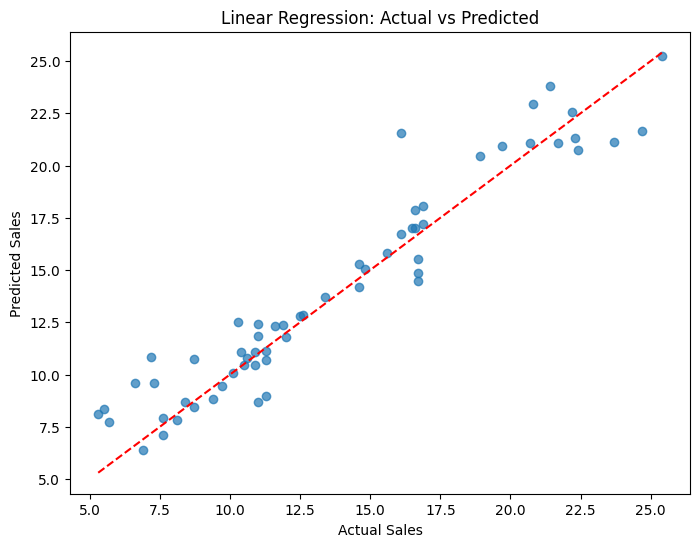

In [ ]:
# visualization of linear regression
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
plt.scatter(y_test, ypredf, alpha=0.7) # aplha means transparency 

# this line below gives the points from where the line should be plotted
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')   # this is as (x,y) so x is y_test.min and max and y is also y_test.min and max
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(' Actual vs Predicted')
plt.show()



In [9]:
df =pd.read_csv("cleaned_data.csv")

x=df[['TV','Radio']]
y=df['Sales']



In [10]:
# train test
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.3, random_state=42)

# scaling these features
scaler=StandardScaler()
x_scaled_train=scaler.fit_transform(x_train)
x_test_scaled= scaler.transform(x_test)


In [11]:
# using ridge regresion
'''  
alpha is the parameter that gives how much value to shrink. 
high value = underfiting more regularization, coefficients becomes smaller
low = overfiting
we have to tune this alpha value as it might result to the wrong value and affect our estimation
to do this we can use the ridgecv i.e. the alpha tuner for ridge regression

'''
import numpy as np
alpha=np.logspace(-4,4,50) # this cretaes a  numpy array of 50 alphas from 10 pwer -4 to 4
ridgecv = RidgeCV(alphas=alpha, cv=5,scoring='neg_mean_squared_error')

# this line below selects the best alpha with the best average cv score and then fits the whole model on that alpha
ridgecv.fit(x_scaled_train, y_train)  # this fits the model of data

ypred=ridgecv.predict(x_test_scaled)  

coefDF= pd.DataFrame({'Feature': x.columns, 'coefficient':ridgecv.coef_})
# evaluation of model
mse=mean_squared_error(y_test,ypred)

rmse=np.sqrt(mse)

r2=r2_score(y_test,ypred)

print("best alpha:", ridgecv.alpha_)
print("mse:", mse)
print("rmse:", rmse)
print("r2 score:", r2)





best alpha: 0.5689866029018293
mse: 2.419560033741487
rmse: 1.5554935016712501
r2 score: 0.9135116702881865


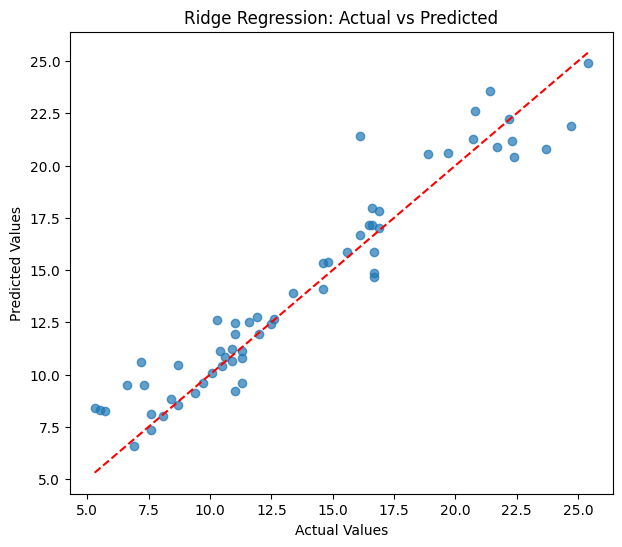

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.scatter(y_test, ypred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal line for perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge Regression: Actual vs Predicted')
plt.show()


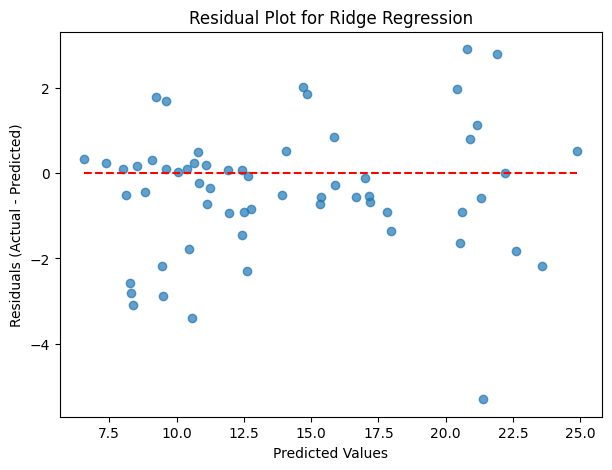

In [23]:
residuals = y_test - ypred

plt.figure(figsize=(7,5))
plt.scatter(ypred, residuals, alpha=0.7)
plt.hlines(0, ypred.min(), ypred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for Ridge Regression')
plt.show()


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
print("Length of x.columns:", len(x.columns))
print("x.columns:", list(x.columns))

print("Shape of final.coef_:", final.coef_.shape)
print("final.coef_:", final.coef_)

print("Shape of ridgecv.coef_:", ridgecv.coef_.shape)
print("ridgecv.coef_:", ridgecv.coef_)

print("Length of Model list Linear Regression:", len(['Linear Regression'] * len(x.columns)))
print("Length of Model list Ridge Regression:", len(['Ridge Regression'] * len(x.columns)))


Length of x.columns: 2
x.columns: ['TV', 'Radio']
Shape of final.coef_: (3,)
final.coef_: [4.52000535 1.61052644 0.18843871]
Shape of ridgecv.coef_: (2,)
ridgecv.coef_: [4.4639337  1.54844208]
Length of Model list Linear Regression: 2
Length of Model list Ridge Regression: 2


(3,)


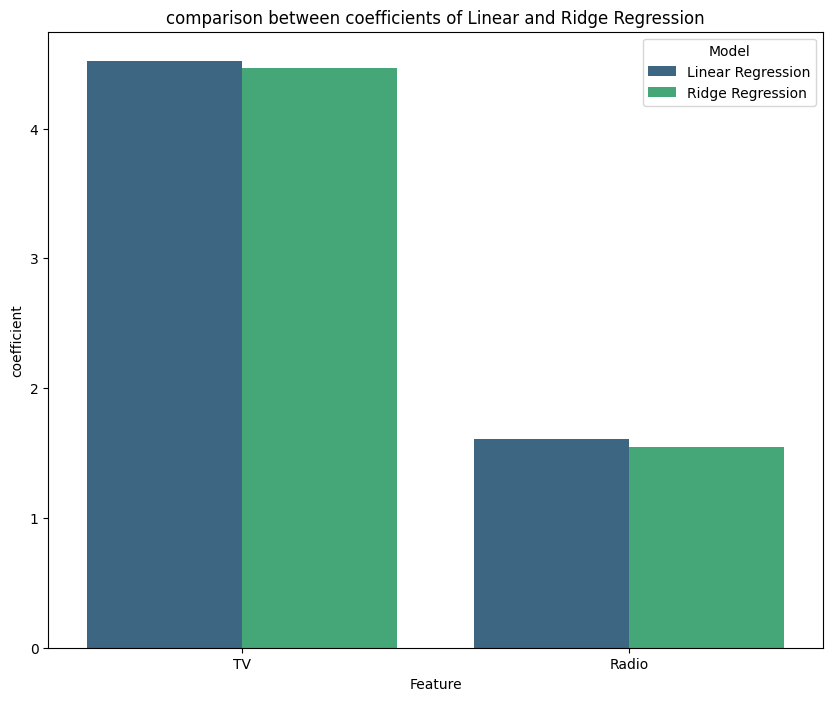

'\n this plot shows the coefficient of the varous features as caluclated by the linear i.e. non penalized and penalized i.e. ridge regression\nThe ridge regression coefficients are smaller than the linear regression coefficients, indicating that ridge regression has applied regularization to reduce the magnitude of the coefficients, which helps prevent overfitting.\n'

In [20]:
# bar plot of the coefficients

# coefficients of the linear regression
''' 
when we make the df from pandas from a dictionary, every list or column must be of the same length
as features and coefficients are of length 3 but the model is of only 1 length string
so either we have to drop this or we have to make this lenth 3
so we did make this length 3
here the x.columns has 2 length only as the x has 2 columns as tv and radio 
so we have to make this plot list with 2 models only

'''
print(final.coef_.shape)
coeflr = pd.DataFrame({
    'Feature': x.columns,
    'coefficient': final.coef_[:len(x.columns)],        # shape (3,) matches x.columns length
    'Model': ['Linear Regression'] * len(x.columns)
})

# coefficients of the ridge  regression
coefridge = pd.DataFrame({
    'Feature': x.columns,
    'coefficient': ridgecv.coef_,
    'Model': ['Ridge Regression'] * len(x.columns)
})
# combining both for plot
coefall= pd.concat([coeflr, coefridge], ignore_index=True)

# plotting the coefficients
plt.figure(figsize=(10,8))

# hue splits the data with the model type and for each model coefficients will be sideways and color will be asssigned different
sns.barplot(data=coefall, x='Feature', y='coefficient', hue='Model' , palette='viridis')

plt.title('comparison between coefficients of Linear and Ridge Regression')
plt.ylabel('coefficient')
plt.show()

'''
 this plot shows the coefficient of the varous features as caluclated by the linear i.e. non penalized and penalized i.e. ridge regression
The ridge regression coefficients are smaller than the linear regression coefficients, indicating that ridge regression has applied regularization to reduce the magnitude of the coefficients, which helps prevent overfitting.
'''